## Amazon Timestream With SageMaker
This is a sample notebook that lets Sagemaker integrate machine learning models
with Amazon Timestream.

In this notebook, we will use Climate data Analysis notebookto visualize Climate data, 
visualize Anamoly scores, 
train a Random Cut Forest (RCF) model using the Climate Records history etc.

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
import timestreamquery as timestream
from IPython import display
import pandas as pd
import boto3
import botocore
import sagemaker
import sys

#################################################
##### Timestream Configurations.  ###############
#################################################
ENDPOINT = "us-east-1" # <--- specify the region service endpoint
PROFILE = "default" # <--- specify the AWS credentials profile
DB_NAME = "testdb" # <--- specify the database created in Amazon Timestream
TABLE_NAME = "climatetable" # <--- specify the table created in Amazon Timestream

client = timestream.createQueryClient(ENDPOINT, profile=PROFILE)

#################################################
##### SageMaker Configurations. #################
#################################################

bucket = 'ccc.s3'   # <--- specify a bucket you have access to
prefix = 'ts/'
execution_role = sagemaker.get_execution_role()
    
# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("You don't have permission to access the bucket, {}".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

us-east-1
Training input/output will be stored in: s3://ccc.s3/ts/


## A helper function to visualize Anomaly scores

In [3]:
def visualizeDataAndAnomalyScores(data, primary, secondary, primaryLabel = 'CPU User', secondaryLabel = 'Anomaly Score'):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(data[primary], color='C0', alpha=0.8)
    ax2.plot(data[secondary], color='C1')

    ax1.grid(which='major', axis='both')

    ax1.set_ylabel(primaryLabel, color='C0')
    ax2.set_ylabel(secondaryLabel, color='C1')

    ax1.tick_params('y', colors='C0')
    ax2.tick_params('y', colors='C1')

    ax1.set_ylim(0, 100)
    ax2.set_ylim(0, 10)
    fig.set_figwidth(10)

## Logical view of data ##
```sql
DESCRIBE <db_name>.<table_name>
```

In [4]:
query = """
DESCRIBE {}.{}
""".format(DB_NAME, TABLE_NAME)

result = timestream.executeQueryAndReturnAsDataframe(client, query, True)

display.display(result)

QueryId: AEBQEAM52E4GONDHIHWIQMFLOBA6IXMLVAJDOVKUCSBFUGJNRFQQ4VDLTKRJ7MQ
2021-07-25 06:48:13. QueryId: AEBQEAM52E4GONDHIHWIQMFLOBA6IXMLVAJDOVKUCSBFUGJNRFQQ4VDLTKRJ7MQ Time: 1.137. First result: 1.137. Time to read results: 0.0.


,Column,Type,Timestream attribute type
0,measure_value::double,double,MEASURE_VALUE
1,measure_name,varchar,MEASURE_NAME
2,time,timestamp,TIMESTAMP
3,Lon,varchar,DIMENSION
4,Lat,varchar,DIMENSION


## Raw query: Visualize the raw data, schema.


* We can run queries at nanosecond level precision
* The query is operating on raw data, rather than any aggregated view.

In [14]:
query = """
SELECT *
FROM {}.{} 
WHERE measure_name = 'DailyRain' 
    AND time > ago(100d)
LIMIT 100
""".format(DB_NAME, TABLE_NAME)

result = timestream.executeQueryAndReturnAsDataframe(client, query, True)

display.display(result)

lat = result['Lat'][0]
lon = result['Lon'][0]

QueryId: AEBQEAM52FGM7HU7XKLYO7LSAJDWGXVZ74WHPKOCGXN5ZI5AMXTUHYHIL6RRL6Y
2021-07-25 07:08:06. QueryId: AEBQEAM52FGM7HU7XKLYO7LSAJDWGXVZ74WHPKOCGXN5ZI5AMXTUHYHIL6RRL6Y Time: 0.265. First result: 0.265. Time to read results: 0.0.


,measure_value::double,measure_name,time,Lon,Lat
0,0.0,DailyRain,2021-04-17 00:00:00.000000000,151.2,-33.85
1,0.0,DailyRain,2021-04-18 00:00:00.000000000,151.2,-33.85
2,0.0,DailyRain,2021-04-19 00:00:00.000000000,151.2,-33.85
3,0.0,DailyRain,2021-04-20 00:00:00.000000000,151.2,-33.85
4,0.0,DailyRain,2021-04-21 00:00:00.000000000,151.2,-33.85
...,...,...,...,...,...
74,22.9,DailyRain,2021-06-30 00:00:00.000000000,151.2,-33.85
75,3.6,DailyRain,2021-07-01 00:00:00.000000000,151.2,-33.85
76,2.7,DailyRain,2021-07-02 00:00:00.000000000,151.2,-33.85
77,0.2,DailyRain,2021-07-03 00:00:00.000000000,151.2,-33.85


## Fetch the Climate Records for the specified duration in the past

In [24]:
def fetchDailyRainTimeseries(duration):
    query = """
SELECT time, measure_value::double AS daily_rain
FROM {0}.{1} 
WHERE measure_name = 'DailyRain' 
    AND time > ago({2})
ORDER BY time ASC
""".format(DB_NAME, TABLE_NAME, duration)

    results = timestream.executeQueryAndReturnAsDataframe(client, query)
    results['daily_rain'] = pd.to_numeric(results['daily_rain'])
    
    return results

## Select the Climate Records for the past several days

In [28]:
DURATION = '100d'  ## Fetch CPU utilization for the past 7 days.

daily_rain = fetchDailyRainTimeseries(DURATION)

display.display(daily_rain)

QueryId: AEBQEAM52FIXD5Z2TIFLNIIAPUPBVBX5AQHH5FWYPFCBNBSZTAIN6I6ZUFVAJCY


,time,daily_rain
0,2021-04-17 00:00:00.000000000,0.0
1,2021-04-18 00:00:00.000000000,0.0
2,2021-04-19 00:00:00.000000000,0.0
3,2021-04-20 00:00:00.000000000,0.0
4,2021-04-21 00:00:00.000000000,0.0
...,...,...
74,2021-06-30 00:00:00.000000000,22.9
75,2021-07-01 00:00:00.000000000,3.6
76,2021-07-02 00:00:00.000000000,2.7
77,2021-07-03 00:00:00.000000000,0.2


## Visualize the data

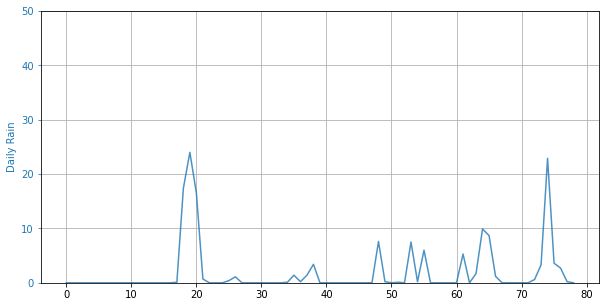

In [29]:
fig, ax1 = plt.subplots()

ax1.plot(daily_rain['daily_rain'], color='C0', alpha=0.8)
ax1.grid(which='major')
ax1.set_ylabel('Daily Rain', color='C0')

ax1.tick_params('y', colors='C0')

ax1.set_ylim(0, 50)
fig.set_figwidth(10)

## Train a Random Cut Forest (RCF) model using the CPU utilization history.

Amazon SageMaker Random Cut Forest (RCF) is an unsupervised algorithm for detecting anomalous data points within a data set. These are observations which diverge from otherwise well-structured or patterned data. Anomalies can manifest as unexpected spikes in time series data, breaks in periodicity, or unclassifiable data points. 

Additional details about the random cut forestt algorithm can be found in the [RCF Algorithm documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html).

Particular to a SageMaker RCF training job are the following hyperparameters:

* **num_samples_per_tree** - the number randomly sampled data points sent to each tree. As a general rule, 1/num_samples_per_tree should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **num_trees** - the number of trees to create in the forest. Each tree learns a separate model from different  samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **feature_dim** - the dimension of each data point.

In addition to these RCF model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role.

In [ ]:
from sagemaker import RandomCutForest

rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(cpu_user.cpu_user.values.reshape(-1,1)))

print('Training job name: {}'.format(rcf.latest_training_job.job_name))

## Deploy the model for inference
We create an inference endpoint using the SageMaker Python SDK deploy() function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up. We recommend using the ml.c5 instance type as it provides the fastest inference time at the lowest cost.

In [ ]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

print('Endpoint name: {}'.format(rcf_inference.endpoint))

## Set up the inference and perform sample inference

We can pass data in a variety of formats to our inference endpoint. In this example we will demonstrate passing CSV-formatted data. Other available formats are JSON-formatted and RecordIO Protobuf. We make use of the SageMaker Python SDK utilities ``csv_serializer`` and ``json_deserializer`` when configuring the inference endpoint.

In [ ]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

cpu_user_reshaped = cpu_user.cpu_user.values.reshape(-1,1)
results = rcf_inference.predict(cpu_user_reshaped[:6])

display.display(results)

## Computing the Anomaly Scores for Data the model Trained on

In [ ]:
results = rcf_inference.predict(cpu_user_reshaped)
scores = [datum['score'] for datum in results['scores']]

# add scores to cpu_user frame and print first few values
cpu_user['score'] = pd.Series(scores, index=cpu_user.index)

#display.display(cpu_user)
cpu_user.head()

## Visualize the data along with Anomaly Scores

In [ ]:
start, end = 0, len(cpu_user)

visualizeDataAndAnomalyScores(cpu_user[start:end], 'cpu_user', 'score')

## Get CPU utilization of a host with similar profile

Use the other host obtained earlier in the run, obtain its CPU utilization and then compute the Anomaly score.

In [ ]:
DURATION = '1d'  ## Fetch CPU utilization for the past 1 day.

avg_cpu_user = fetchCpuUserTimeseries(DURATION, REGION, CELL, SILO, AZ, MICROSERVICE_NAME, AVG_CPU_HOST2)

display.display(avg_cpu_user)

## Compute Anomaly Score

In [ ]:
results = rcf_inference.predict(avg_cpu_user.cpu_user.values.reshape(-1,1))
scores = [datum['score'] for datum in results['scores']]

# add scores to cpu_user frame and print first few values
avg_cpu_user['score'] = pd.Series(scores, index=avg_cpu_user.index)

avg_cpu_user.head()

## Visualize Data and Anomaly Scores

In [ ]:
start, end = 0, len(cpu_user)

visualizeDataAndAnomalyScores(avg_cpu_user[start:end], 'cpu_user', 'score')

## Leverage Timestream to find a high CPU utilization host

Leverage Timestream's sophisticated analytics functionality and expressive query language to find a set of high CPU utilization hosts

In [ ]:
## Find High CPU hosts.
DURATION = "1h"
query = """
WITH region_avg AS 
(
    SELECT avg(measure_value::double) AS threshold 
    FROM {0}.{1} 
    WHERE region = '{3}' AND  
        measure_name = 'cpu_user' AND
        time > ago({2})
), 
host_avg AS 
(
    SELECT region, cell, silo, availability_zone, microservice_name, instance_name, 
        avg(measure_value::double) AS average_value 
    FROM {0}.{1} 
    WHERE region = '{3}' AND
        measure_name = 'cpu_user' AND
        time > ago({2}) 
    GROUP BY region, cell, silo, availability_zone, microservice_name, instance_name
) 

SELECT region, cell, silo, availability_zone, microservice_name,
    host_avg.instance_name AS high_cpu_hosts, 
    host_avg.average_value AS inst_avg, 
    region_avg.threshold AS region_avg_threshold
FROM region_avg, host_avg 
WHERE host_avg.average_value > (1.1 * region_avg.threshold)
LIMIT 10
""".format(DB_NAME, TABLE_NAME, DURATION, REGION)

result = timestream.executeQueryAndReturnAsDataframe(client, query)
display.display(result)

HIGH_CPU_HOST = result['high_cpu_hosts'][0]
REGION = result['region'][0]
AZ = result['availability_zone'][0]
MICROSERVICE_NAME = result['microservice_name'][0]
CELL = result['cell'][0]
SILO = result['silo'][0]

## Get CPU utilization of a high CPU hosts

In [ ]:
DURATION = '1d'
high_cpu_user = fetchCpuUserTimeseries(DURATION, REGION, CELL, SILO, AZ, MICROSERVICE_NAME, HIGH_CPU_HOST)

display.display(high_cpu_user)

## Get Anomaly scores for this host's CPU utilization

In [ ]:
high_cpu_user_reshaped = high_cpu_user.cpu_user.values.reshape(-1,1)

results = rcf_inference.predict(high_cpu_user_reshaped)
high_cpu_scores = [datum['score'] for datum in results['scores']]

# add scores to taxi data frame and print first few values
high_cpu_user['score'] = pd.Series(high_cpu_scores, index=high_cpu_user.index)

#display.display(high_cpu_user)
high_cpu_user.head()

## Visualize the data along with the high CPU utilization hosts

In [ ]:
start, end = 0, len(cpu_user)

visualizeDataAndAnomalyScores(high_cpu_user[start:end], 'cpu_user', 'score')

## Find hosts with Low CPU utilization

In [ ]:
DURATION = "1h"
query = """
WITH region_avg AS 
(
    SELECT avg(measure_value::double) AS threshold 
    FROM {0}.{1} 
    WHERE region = '{3}' AND  
        measure_name = 'cpu_user' AND
        time > ago({2})
), 
host_avg AS 
(
    SELECT region, cell, silo, availability_zone, microservice_name, instance_name, 
        avg(measure_value::double) AS average_value 
    FROM {0}.{1} 
    WHERE region = '{3}' AND
        measure_name = 'cpu_user' AND
        time > ago({2}) 
    GROUP BY region, cell, silo, availability_zone, microservice_name, instance_name
) 

SELECT region, cell, silo, availability_zone, microservice_name,
    host_avg.instance_name AS low_cpu_hosts, 
    host_avg.average_value AS inst_avg, 
    region_avg.threshold AS region_avg_threshold
FROM region_avg, host_avg 
WHERE host_avg.average_value < (0.9 * region_avg.threshold)
LIMIT 10
""".format(DB_NAME, TABLE_NAME, DURATION, REGION)

result = timestream.executeQueryAndReturnAsDataframe(client, query, True)
display.display(result)

LOW_CPU_HOST = result['low_cpu_hosts'][0]
REGION = result['region'][0]
AZ = result['availability_zone'][0]
MICROSERVICE_NAME = result['microservice_name'][0]
CELL = result['cell'][0]
SILO = result['silo'][0]

## Get the CPU utilization for the host with Low CPU utilization

In [ ]:
DURATION = '1d'
low_cpu_user = fetchCpuUserTimeseries(DURATION, REGION, CELL, SILO, AZ, MICROSERVICE_NAME, LOW_CPU_HOST)

display.display(low_cpu_user)

## Compute the Anomaly Scores

In [ ]:
low_cpu_user_reshaped = low_cpu_user.cpu_user.values.reshape(-1,1)

results = rcf_inference.predict(low_cpu_user_reshaped)
low_cpu_scores = [datum['score'] for datum in results['scores']]

low_cpu_user['score'] = pd.Series(low_cpu_scores, index=low_cpu_user.index)

low_cpu_user.head()

## Visualize the data and Anomaly scores

In [ ]:
start, end = 0, len(low_cpu_user) 
low_cpu_user_subset = low_cpu_user[start:end]

visualizeDataAndAnomalyScores(low_cpu_user[start:end], 'cpu_user', 'score')

## Find anomalous hosts

We now use the model to identify hosts with anomalous CPU utilization.
* For each host, we obtain the time series of their per minute average CPU utilization.
* Use the model to compute the anomaly score for the CPU utilization time series.
* Identify hosts that have a high anomaly score.

In [ ]:
DURATION = '1h'
query = """
WITH binned_cpu AS (
    SELECT region, cell, silo, availability_zone, microservice_name, instance_name, 
        bin(time, 1m) AS time_bin, ROUND(avg(measure_value::double), 3) AS cpu_user
    FROM {0}.{1}
    WHERE time > ago({2})
        AND measure_name = 'cpu_user'
        AND region = '{3}' AND cell = '{4}'
    GROUP BY region, cell, silo, availability_zone, microservice_name, instance_name, bin(time, 1m)
)
SELECT region, cell, silo, availability_zone, microservice_name, instance_name, CREATE_TIME_SERIES(time_bin, cpu_user) AS cpu_user_ts
FROM binned_cpu
GROUP BY region, cell, silo, availability_zone, microservice_name, instance_name
""".format(DB_NAME, TABLE_NAME, DURATION, REGION, CELL)

per_host_timeseries = timestream.executeQueryAndReturnAsDataframe(client, query, True)

display.display(per_host_timeseries)

In [ ]:
import numpy as np

ANOMALY_THRESHOLD = 4

anomalous_hosts = list()
for item in per_host_timeseries.itertuples():
    # Reshape the data as sought by the model
    cpu_util = np.reshape([[x['value']] for x in item.cpu_user_ts], (-1,1))
    
    # Invoke inference to get the anomaly score.
    results = rcf_inference.predict(cpu_util)
    result_cpu_scores = [datum['score'] for datum in results['scores']]
    
    # Identify anomalous hosts by averaging the anomaly scores for all measurements
    # and checking if it is greater than a threshold.
    if np.average(result_cpu_scores) > ANOMALY_THRESHOLD:
        anomalous_hosts.append(item)
        
print("Fractional anomalous hosts: {}".format(round(len(anomalous_hosts)/len(per_host_timeseries.index), 3)))
for item in anomalous_hosts:
    print("[Region: {}, Cell: {}, Silo: {}, Microservice: {}, Instance name: {}]. Avg CPU: {}".format(
        item.region, item.cell, item.silo, item.microservice_name, item.instance_name,
        round(np.average([y['value'] for y in item.cpu_user_ts])), 3))

## Stop and Delete the Endpoint
Finally, we should delete the endpoint before we close the notebook.

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable endpoint_name, and select "Delete" from the "Actions" dropdown menu.

In [ ]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

## Other models relevant to time series

* [**DeepAR Forecasting Algorithm**](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html)
    * Example Notebooks
        * [Timeseries forecasting with DeepAR - Synthetic data](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/deepar_synthetic/deepar_synthetic.ipynb)
        * [SageMaker/DeepAR demo on electricity dataset](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/deepar_electricity/DeepAR-Electricity.ipynb)